In [1]:
%matplotlib inline

In [62]:
# import functools
# def wrap_method(cls, name):
#     # This unbound method will be pulled from the superclass.
#     wrapped = getattr(cls, name)
#     @functools.wraps(wrapped)
#     def wrapper(self, *args, **kwargs):
#         return self._in(wrapped.__get__(self, cls), *args, **kwargs)
#     return wrapper


def wrap(k, prop=False):
    print('create')
    def _get_prop(self):
        return [getattr(x, k) for x in self._datas]
    if prop:
        _get_prop = property(_get_prop)

    return _get_prop


def wrap_methods(methods, prop=True):
    def wrap_methods_inner(cls):
        for name in methods:
            setattr(cls, name, wrap(name, prop))
        return cls
    return wrap_methods_inner


In [63]:
class data(object):
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

@wrap_methods(['a','b'], prop=True)
@wrap_methods(['c'], prop=False)
class data_list(object):
    def __init__(self, datas):
        self._datas = datas
        
#     def _get_prop(self, k):
#         return [getattr(x, k) for x in self._datas]
        
        
        


create
create
create


In [64]:
x = data(1,2,3)
y = data(-1,-2,-3)
X = data_list([x,y])


In [65]:
X.c()

[3, -3]

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from importlib import reload

In [67]:
#function to tag 'LD' and 'HD' phases
def tag_phases(x):
    if x.base.num_phases_max !=2:
        raise ValueError('bad tag function')
        

    if x.nphase==1:
        if x[0].density.values<0.5:
            return np.array([0])
        else:
            return np.array([1])
    
    elif x.nphase==2:
        return np.argsort(-x.argmax[0])
    else:
        raise ValueError('bad nphase')
    
            

# create a reference lnPi_phases for bulk case

In [138]:
import lnPi
reload(lnPi.spinodal)
reload(lnPi)

#from data
data = np.loadtxt('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat')


lnpi_bulk = lnPi.lnPi_phases.from_data(data,mu=-8.6160,volume=729.00,beta=1.0/0.7,
                                       num_phases_max=2,                                       
                                       argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                       ftag_phases=tag_phases)

        

In [201]:
data = pd.read_csv('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat', sep='\s+', header=None, index_col=False, names=['N_0','lnpi']).set_index('N_0')['lnpi'].to_xarray().values




base = lnPi.lnPi(data=data, mu=-8.6160, volume=729.0, beta=1.0/0.7, num_phases_max=2, fill_value=np.nan, mask=False)

In [202]:
import xarray as xr

In [204]:
pi = xr.DataArray(base.pi.filled(), dims=['N_0'])
pi_norm = pi / pi.sum()

In [211]:
Nave = (pi_norm * pi_norm.N_0).sum()


In [214]:
base.Nave

<xarray.DataArray 'Nave' (component: 1)>
array([598.928013])
Coordinates:
    mu_0     float64 -8.616
    beta     float64 1.429
Dimensions without coordinates: component

In [182]:
base.mask[200:] = np.ma.masked

In [180]:
base.mask[200:] = True

In [185]:
base[200:] = np.ma.masked

In [187]:
base.mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [168]:
base.fill_value = np.nan

In [170]:
base.filled()

array([ -18.0616103,  -17.1565719,  -16.9198476,  -17.0637165,
        -17.4704027,  -18.0750106,  -18.8368841,  -19.7280741,
        -20.7278385,  -21.8209366,  -22.9936916,  -24.2359998,
        -25.5399163,  -26.8979013,  -28.3040303,  -29.7525683,
        -31.2407623,  -32.7628343,  -34.3157913,  -35.8968853,
        -37.5017173,  -39.1293323,  -40.7755303,  -42.4384293,
        -44.1166313,  -45.8071703,  -47.5078503,  -49.2168983,
        -50.9325973,  -52.6530243,  -54.3759113,  -56.0996473,
        -57.8225723,  -59.5419703,  -61.2555133,  -62.9603213,
        -64.6550143,  -66.3370813,  -68.0033343,  -69.6528953,
        -71.2826143,  -72.8895493,  -74.4720763,  -76.0303163,
        -77.5627583,  -79.0689543,  -80.5505103,  -82.0070803,
        -83.4392963,  -84.8492033,  -86.2385083,  -87.6078723,
        -88.9587353,  -90.2921693,  -91.6093103,  -92.9113743,
        -94.1996063,  -95.4726743,  -96.7333803,  -97.9825763,
        -99.2204463, -100.4465873, -101.6620763, -102.8

In [ ]:
xr.DataArray(base)

In [153]:
base.Nave

<xarray.DataArray 'Nave' (component: 1)>
array([598.928013])
Coordinates:
    mu_0     float64 -8.616
    beta     float64 1.429
Dimensions without coordinates: component

In [129]:
dims = tuple(['N_{}'.format(i) for i in range(base.ndim)])
data = base.data
mask = base.mask
coords = {}
attrs = base._optinfo
coords['mask'] = (dims, mask)

In [131]:
base

masked_array(data=[-1.80616103e+01, -1.71565719e+01, -1.69198476e+01,
                   -1.70637165e+01, -1.74704027e+01, -1.80750106e+01,
                   -1.88368841e+01, -1.97280741e+01, -2.07278385e+01,
                   -2.18209366e+01, -2.29936916e+01, -2.42359998e+01,
                   -2.55399163e+01, -2.68979013e+01, -2.83040303e+01,
                   -2.97525683e+01, -3.12407623e+01, -3.27628343e+01,
                   -3.43157913e+01, -3.58968853e+01, -3.75017173e+01,
                   -3.91293323e+01, -4.07755303e+01, -4.24384293e+01,
                   -4.41166313e+01, -4.58071703e+01, -4.75078503e+01,
                   -4.92168983e+01, -5.09325973e+01, -5.26530243e+01,
                   -5.43759113e+01, -5.60996473e+01, -5.78225723e+01,
                   -5.95419703e+01, -6.12555133e+01, -6.29603213e+01,
                   -6.46550143e+01, -6.63370813e+01, -6.80033343e+01,
                   -6.96528953e+01, -7.12826143e+01, -7.28895493e+01,
                   -

In [75]:
lnpi_bulk.phases[0].argmax()

2

In [134]:
#from file
lnpi_bulk = lnPi.lnPi_phases.from_file('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat',
                                       mu=-8.6160,volume=729.00,beta=1.0/0.7,
                                       num_phases_max=2,                                       
                                       argmax_kwargs=dict(min_distance=[5,10,20,40]),ftag_phases=tag_phases)

In [137]:
lnpi_bulk.base.mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [7]:
#from matrix 1
val = data[:,-1]
lnpi_bulk = lnPi.lnPi(data = val,mask=False,num_phases_max=2,mu=-8.6160, volume=729., beta=1./0.7).to_phases(
    argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                   ftag_phases=tag_phases)

In [8]:
#from matrix 2 (better)
Z = np.loadtxt('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat')[:,-1]
#Z is the  'matrix' of lnPis, 1D in this case

In [9]:
print(Z[:20])

[-20.71351647 -19.80847807 -19.57175377 -19.71562267 -20.12230887
 -20.72691677 -21.48879027 -22.37998027 -23.37974467 -24.47284277
 -25.64559777 -26.88790597 -28.19182247 -29.54980747 -30.95593647
 -32.40447447 -33.89266847 -35.41474047 -36.96769747 -38.54879147]


In [10]:
lnpi_bulk = lnPi.lnPi_phases.from_matrix(Z,mu=-8.6160,volume=729.00,beta=1.0/0.7,
                                       num_phases_max=2,                                       
                                       argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                       ftag_phases=tag_phases)

## create a collection

In [11]:
import lnPi
reload(lnPi.spinodal)
reload(lnPi)

#from data
data = np.loadtxt('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat')


lnpi_bulk = lnPi.lnPi_phases.from_data(data,mu=-8.6160,volume=729.00,beta=1.0/0.7,
                                       num_phases_max=2,                                       
                                       argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                       ftag_phases=tag_phases)

        

In [12]:
#collection of lnpis
C = lnPi.lnPi_collection.from_mu(lnpi_bulk,[None],np.linspace(-12,-5,20))

In [14]:
#set spinodal/binodal
C.get_spinodals()
C.get_binodals()
#sort by mu
C.sort_by_mu(inplace=True)

In [15]:
print(C.spinodals[0]._repr_html_())
print(C.spinodals[1]._repr_html_())
print(C.binodals[0]._repr_html_())

lnPi_phases: nphase=2, mu=[-7.46824698]
lnPi_phases: nphase=2, mu=[-9.58832717]
lnPi_phases: nphase=2, mu=[-8.63733388]


In [112]:
def make_Omega_vs_mu_phase_plot(C,spin=None,bino=None,ax=None,ax_labels=True):
    if ax is None:
        fig,ax = plt.subplots()
        
    if spin is None:
        spin = C.spinodals

    if bino is None:
        bino = C.binodals[0]
    
    for phase, g in C.Omega_phase().groupby('phase'):
        ax.plot(g.mu_0, g)
#     for phase, g in C.Omegas_phaseIDs().reset_index().groupby('phase'):
#         g.plot('mu_0','Omega', ax=ax)
    colors = [l.get_color() for l in ax.lines]
    
    for phase, (s, c) in enumerate(zip(spin, colors)):
        s.Omega_phase().sel(phase=phase).pipe(lambda x: ax.plot(x.mu_0, x, marker='o', color=c))
    
    bino.Omega_phase().sel(phase=0).pipe(lambda x: ax.plot(x.mu_0, x, marker='s', color='k'))
#     for phase, (s, c) in enumerate(zip(spin, colors)):
#         s.Omegas_phaseIDs().xs(phase, level='phase').reset_index().plot('mu_0','Omega', marker='o', color=c, ax=ax)
#     bino.Omegas_phaseIDs().xs(0, level='phase').reset_index().plot('mu_0','Omega', marker='s', color='k', ax=ax)
    


    if ax_labels:
        ax.set_ylabel(r'$\Omega^{ex}$')
        ax.set_xlabel(r'$\mu$')
    

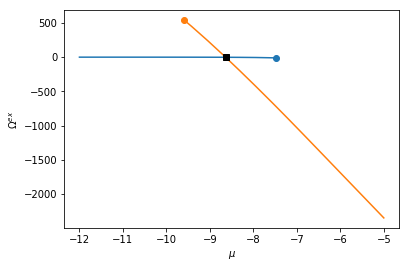

In [113]:
#plot
make_Omega_vs_mu_phase_plot(C)

# bulk 065

In [114]:
lnpi_bulk = lnPi.lnPi_phases.from_file('./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat',mu=-4.453015418106743E+00,
                               volume=1000.0E0,num_phases_max=2,beta=1./0.65000E0,ZeroMax=True,fill_value=np.nan,
                                      argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                ftag_phases=tag_phases)

In [115]:
Cbulk = lnPi.lnPi_collection.from_mu(lnpi_bulk,[None],np.linspace(-7,.2,50))
Cbulk.get_spinodals()
Cbulk.get_binodals()

Cbulk.sort_by_mu(inplace=True)

In [119]:
Cbulk[0].base.volume

1000.0

In [121]:
psat = (-Cbulk.binodals[0].Omega_phase().sel(phase=0) / Cbulk[0].base.volume).values

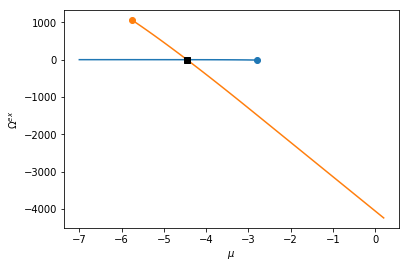

In [122]:
make_Omega_vs_mu_phase_plot(Cbulk)

# confined

In [123]:
def tag_phases_conf(x):
    if x.base.num_phases_max !=2:
        raise ValueError('bad tag function')
        
    L = []
    for p in x.phases:
        if p.density.values<0.5:
            val = 0
        else:
            val = 1
        L.append(val)
        
    L = np.array(L)
    


    return L

In [124]:
#make up a volume

lnpi_conf = lnPi.lnPi_phases.from_file('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat',
                                mu=-0.500000E+01,volume=7000.,beta=1./0.65000E0,
                                num_phases_max=2,ZeroMax=True,fill_value=np.nan,
                                      argmax_kwargs=dict(min_distance=[5,10,20,40]),ftag_phases=tag_phases_conf,
                                build_kwargs=dict(merge_phaseIDs=True))

In [125]:
Cconf = lnPi.lnPi_collection.from_mu(lnpi_conf,[None],np.linspace(-5.2,-5.0,50)) #np.linspace(-8,-5,10)
Cconf.get_spinodals()
Cconf.get_binodals()
Cconf.sort_by_mu(inplace=True)

/Users/wpk/Documents/python/lnPi/__init__.py:1667: RuntimeWarning: All-NaN slice encountered
  new_row = np.nanmin(Etrans[[idx_kill, idx_keep], :], axis=0)
/Users/wpk/Documents/python/lnPi/__init__.py:1667: RuntimeWarning: All-NaN slice encountered
  new_row = np.nanmin(Etrans[[idx_kill, idx_keep], :], axis=0)
/Users/wpk/Documents/python/lnPi/__init__.py:1667: RuntimeWarning: All-NaN slice encountered
  new_row = np.nanmin(Etrans[[idx_kill, idx_keep], :], axis=0)
/Users/wpk/Documents/python/lnPi/__init__.py:1667: RuntimeWarning: All-NaN slice encountered
  new_row = np.nanmin(Etrans[[idx_kill, idx_keep], :], axis=0)
/Users/wpk/Documents/python/lnPi/__init__.py:1667: RuntimeWarning: All-NaN slice encountered
  new_row = np.nanmin(Etrans[[idx_kill, idx_keep], :], axis=0)
/Users/wpk/Documents/python/lnPi/__init__.py:1667: RuntimeWarning: All-NaN slice encountered
  new_row = np.nanmin(Etrans[[idx_kill, idx_keep], :], axis=0)
/Users/wpk/Documents/python/lnPi/__init__.py:1667: RuntimeWarnin

(-5.14, -5.09)

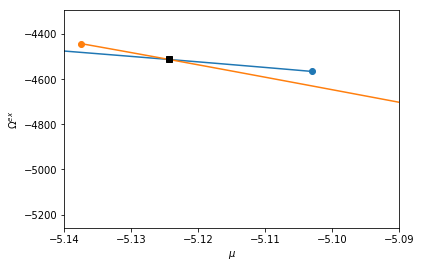

In [126]:
make_Omega_vs_mu_phase_plot(Cconf.merge_phases(efac=0.9),Cconf.spinodals,Cconf.binodals[0])


ax=plt.gca()
ax.set_xlim(-5.14,-5.09)

In [127]:
df=pd.read_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt',sep='\s+',
                 header=None,names=['pscaled','mu','rho','Omega_L','Qst','Gads'])


/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [128]:
#make isotherm

In [129]:
a = np.linspace(-20,Cconf.spinodals[1].mu[0],100)
b = np.linspace(Cconf.spinodals[1].mu[0],Cconf.spinodals[0].mu[0],100)
c = np.linspace(Cconf.spinodals[0].mu[0],Cbulk.binodals[0].mu[0],100)
mus = np.concatenate((a,b,c))

In [130]:
Cb = lnPi.lnPi_collection.from_mu(lnpi_bulk,[None],x=mus)
Cc = lnPi.lnPi_collection.from_mu_iter(lnpi_conf,Cb.mus)

In [131]:
P = (-Cb.Omega_phase().sel(phase=0) / Cb[0].base.volume / psat).rena

In [135]:
rho = Cc.Nave_phase

In [139]:
P.to_dataframe().drop('phase', axis=1).head()

,mu_0,beta,Omega
rec,,,
0,-20.000000,1.538462,4.053063e-11
1,-19.849873,1.538462,5.106112e-11
2,-19.699746,1.538462,6.432765e-11
3,-19.549619,1.538462,8.104093e-11
4,-19.399492,1.538462,1.020965e-10


In [149]:
iso = rho.to_dataframe().reset_index().merge(P.rename('pressure').to_dataframe().drop('phase', axis=1), on=['mu_0','beta'])

(0, 1.0)

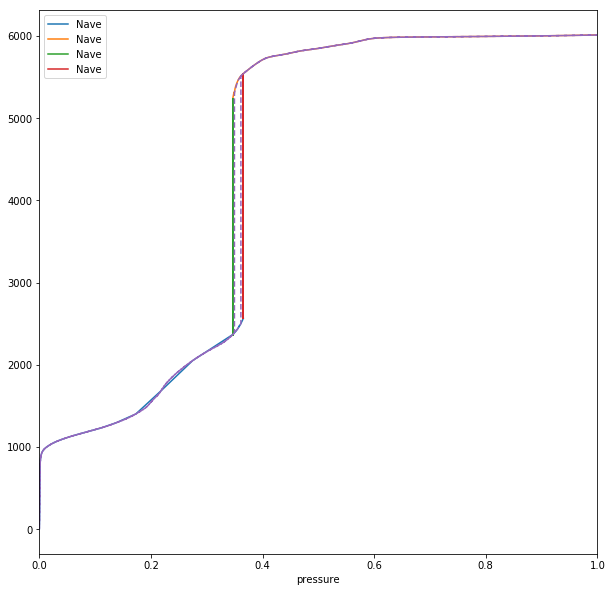

In [151]:
fig,ax = plt.subplots(figsize=(10,10))
for phase, g in iso.groupby('phase'):
    g.plot('pressure','Nave', ax=ax)

iso.query('mu_0==@b[0]').drop_duplicates().plot('pressure','Nave', ax=ax)
iso.query('mu_0==@b[-1]').drop_duplicates().plot('pressure','Nave', ax=ax)

plt.plot(df.pscaled,df.rho,'--')
plt.gca().set_xlim(0,1.0)


(0.3, 0.5)

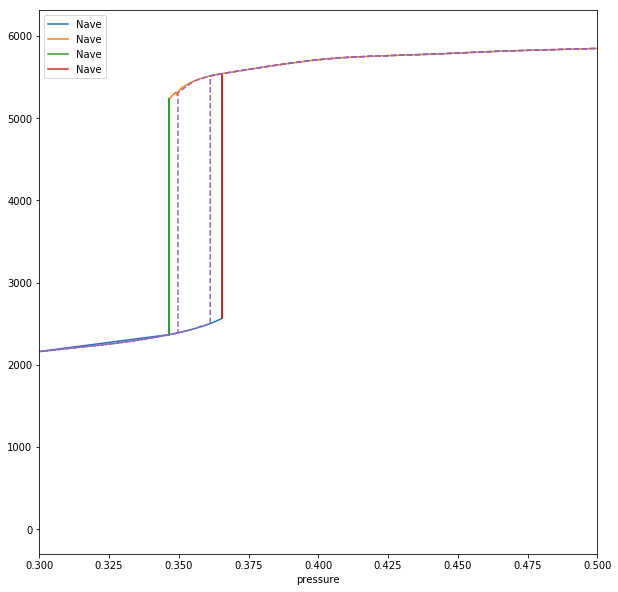

In [152]:
fig,ax = plt.subplots(figsize=(10,10))
for phase, g in iso.groupby('phase'):
    g.plot('pressure','Nave', ax=ax)

iso.query('mu_0==@b[0]').drop_duplicates().plot('pressure','Nave', ax=ax)
iso.query('mu_0==@b[-1]').drop_duplicates().plot('pressure','Nave', ax=ax)

plt.plot(df.pscaled,df.rho,'--')
plt.gca().set_xlim(0.3,0.5)
